In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from adjustText import adjust_text

from scipy.stats import ks_2samp, ttest_ind
from statsmodels.stats.multitest import multipletests

import scvi
from scvi.model import CondSCVI, DestVI

import umap
import torch
from torch.distributions import Gamma
import gseapy
import hotspot

import base64
from io import BytesIO

from utils import *

%matplotlib inline

# import data and collide cell-types

In [4]:
sc_adata = sc.read_h5ad("scRNA-Tumor-compressed.h5ad")

In [5]:
sc_adata.obs["broad_labels"].value_counts()

Mon-Mac        4400
CD8            1021
CD4-Tregs       833
DCs             502
Neutrophils     186
NK              155
Tumor            88
Name: broad_labels, dtype: int64

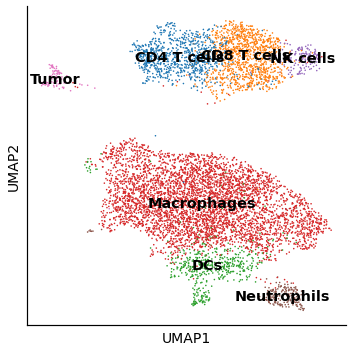

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.umap(
    sc_adata, 
    color="broad_labels_",
    frameon=True,
    title="",
    legend_loc="on data",
    legend_fontsize="x-large",
    ax=ax, size=10, show=False,
)
plt.tight_layout()
plt.savefig("figures/UMAP_scRNA.pdf", dpi=DPI)

In [7]:
sc_adata.obs["broad_labels"].value_counts().sum()

7185

In [8]:
G = 4000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [9]:
sc_adata

AnnData object with n_obs × n_vars = 7185 × 4000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'broad_labels', 'broad_labels_', 'ABfile', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'leiden_2'
    var: 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', 'broad_labels_colors', 'leiden', 'leiden_2_colors', 'neighbors', 'umap', 'broad_labels__colors', 'hvg', 'log1p'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## get intersection with spatial

In [10]:
st_adata = sc.read_h5ad("ST-Tumor-compressed.h5ad")

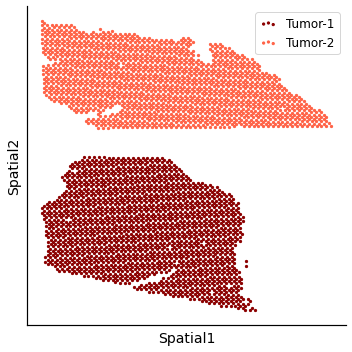

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
color_list = ["darkred", "tomato"]
name_list = ["Tumor-1", "Tumor-2"]
for i, value in enumerate(["A1", "B1"]):
    mask = st_adata.obs["tumor"] == value
    ax.scatter(st_adata.obsm["location"][mask, 0], st_adata.obsm["location"][mask, 1], 
               c=color_list[i], label=name_list[i], s=5)
ax.legend(frameon=True)
prettify_axis(ax, False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Spatial1")
ax.set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/spatial.pdf", dpi=DPI)

In [12]:
st_adata.obs["tumor"].value_counts(), st_adata.n_obs

(A1    2125
 B1    1902
 Name: tumor, dtype: int64,
 4027)

In [13]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [14]:
G = len(intersect)
print(G)

2886


In [15]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

## fit scRNA-seq model

In [16]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="broad_labels")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_labels"]                                         
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 7185 cells, 2886 vars, 1 batches, 
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
train = False
if train:
    # train the conditional VAE
    sc_model = CondSCVI(sc_adata)
    sc_model.train(max_epochs=350)
    sc_model.history["elbo_train"].plot()
    sc_model.save("sc_model", overwrite=True)
else:
    sc_model = CondSCVI.load("CondSCVI", sc_adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 7185 cells, 2886 vars, 1 batches, 
         7 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
sc_adata.obsm["X_CondSCVI"] = sc_model.get_latent_representation()

## Deconvolution

In [21]:
# get dataset ready
scvi.data.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4027 cells, 2886 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|██████████| 2500/2500 [25:44<00:00,  1.62it/s, loss=1.2e+07, v_num=1] 


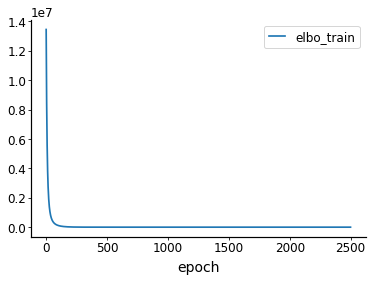

In [22]:
# add here number of cell type
train_st = False
if train_st:
    st_model = DestVI.from_rna_model(st_adata, sc_model)
    st_model.train(max_epochs=2500)
    st_model.history["elbo_train"].plot()
    st_model.save("st_model", overwrite=True)
else:
    st_model = DestVI.load("st_model", st_adata)

In [23]:
st_adata.obsm["proportions"] = st_model.get_proportions()
gamma = st_model.get_gamma(return_numpy=True)

## Statistics on proportions

In [24]:
loc = pd.DataFrame(data=st_adata.obsm["location"], index=st_adata.obs.index)
hs = hotspot.Hotspot(st_adata.obsm["proportions"].T, model='none', latent=loc,)

hs.create_knn_graph(
    weighted_graph=True, n_neighbors=50,
)

hs_results = hs.compute_autocorrelations(jobs=1)

hs_results

100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


C          Z           Pval            FDR
Gene                                                          
Mon-Mac      0.967287  50.526922   0.000000e+00   0.000000e+00
Tumor        0.973354  31.640035  5.198993e-220  1.819647e-219
DCs          0.797970   4.024450   2.855427e-05   6.662662e-05
Neutrophils  0.781946   0.498133   3.091953e-01   4.796175e-01
CD4-Tregs    0.475414   0.163515   4.350563e-01   4.796175e-01
CD8          0.497156   0.130325   4.481545e-01   4.796175e-01
NK           0.563871   0.051114   4.796175e-01   4.796175e-01

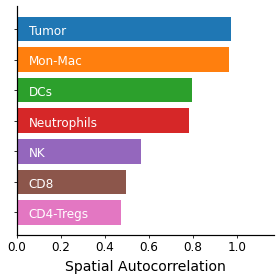

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.margins(x=0.2)
bar_data = hs_results.sort_values("C", ascending=True)
ax.barh(np.arange(bar_data.shape[0]), bar_data["C"].values, 
                            color=sns.color_palette()[0:bar_data.shape[0]][::-1])
ax.set_yticks(np.arange(bar_data.shape[0]))
ax.set_yticklabels( bar_data.index.values, horizontalalignment = "left", color="white")
ax.set_xlabel("Spatial Autocorrelation")
ax.tick_params(axis='y', pad=-15)
plt.tight_layout()
plt.savefig("figures/geary.pdf", dpi=300)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


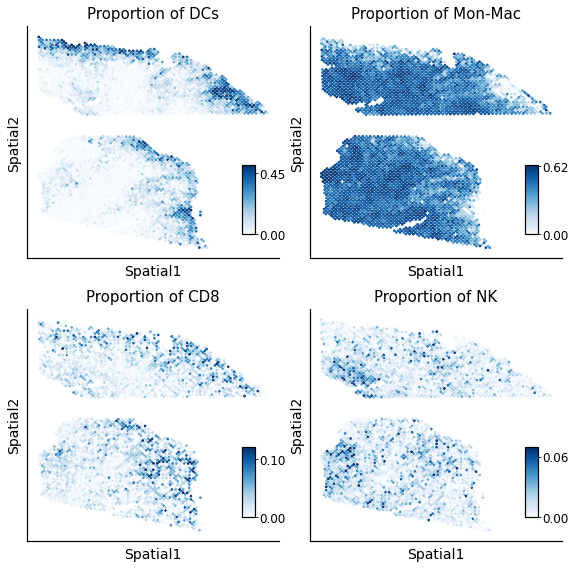

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ct_list = ["DCs", "Mon-Mac", "CD8", "NK"]
for i in range(2):
    for j in range(2):           
        prettify_axis(axes[i, j], False)
        data = st_adata.obsm["proportions"][ct_list[i*2 + j]]
        vmax = np.quantile(data, 0.99)
        scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=data, s=3, cmap="Blues", vmax=vmax)
        a, b = np.quantile(data, 0.01),np.quantile(data, 0.98)
        ta, tb = ["{:0.2f}".format(x) for x in (a, b)]
        cax = inset_axes(axes[i, j], width="5%", height="30%", loc=4, borderpad=2) 
        cbar = plt.colorbar(scplot, cax=cax, orientation="vertical")
        cbar.set_ticks([a, b])
        cbar.set_ticklabels([ta, tb])
        axes[i, j].set_title(F"Proportion of {ct_list[i*2+j]}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel("Spatial1")
        axes[i, j].set_ylabel("Spatial2")
plt.tight_layout()
plt.savefig("figures/proportions.pdf", dpi=DPI)

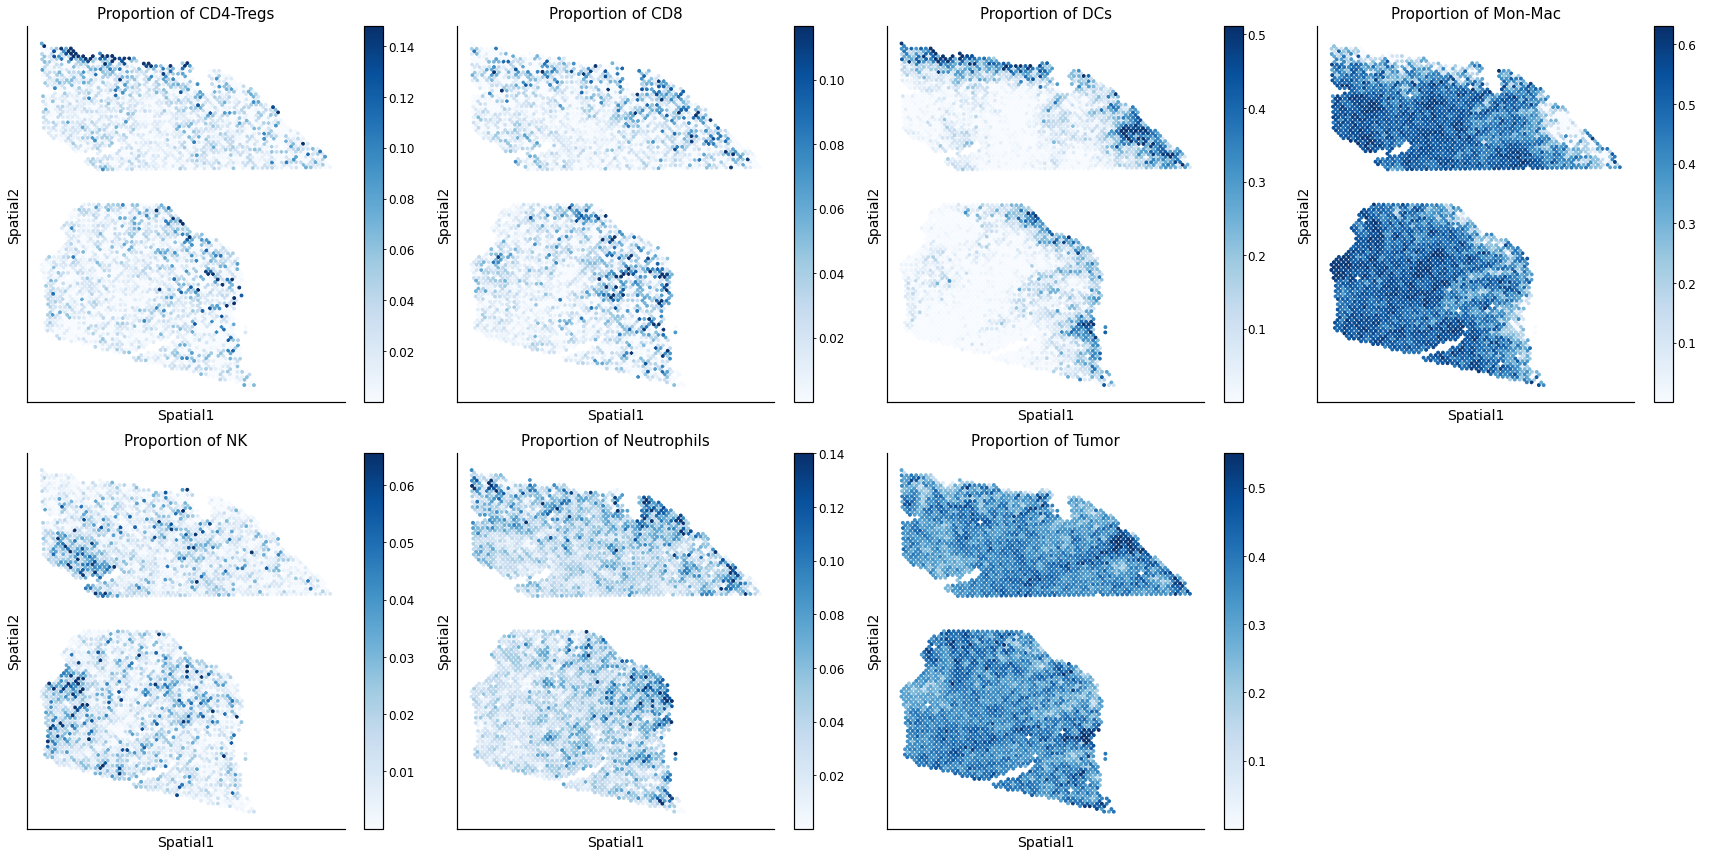

In [36]:
# all cell types for supplements
# selected cell type for paper
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
ct_list = st_adata.obsm["proportions"].columns
for i in range(2):
    for j in range(4):
        if i*4 + j < 7:
            prettify_axis(axes[i, j], False)
            data = st_adata.obsm["proportions"][ct_list[i*4 + j]]
            vmax = np.quantile(data, 0.99)
            scplot = axes[i, j].scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=data, s=8, cmap="Blues", vmax=vmax)
            plt.colorbar(scplot, ax=axes[i, j])
            axes[i, j].set_title(F"Proportion of {ct_list[i*4+j]}")
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_xlabel("Spatial1")
            axes[i, j].set_ylabel("Spatial2")
        else:
            prettify_axis(axes[i, j], True)

plt.tight_layout()
plt.savefig("figures/proportions_supp.pdf", dpi=DPI)

##  Show proportion for every cell type spatially and find characteristic proportions

100%|██████████| 100/100 [00:00<00:00, 7748.00it/s]


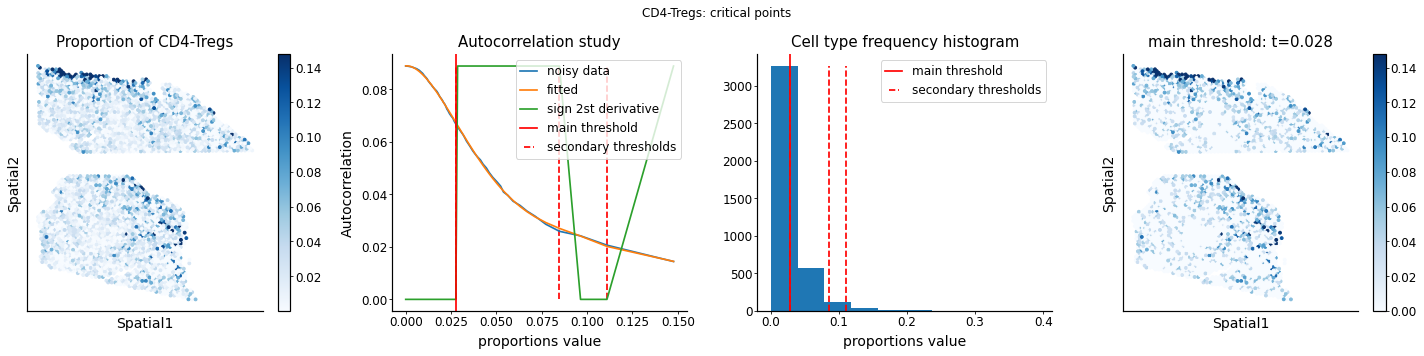

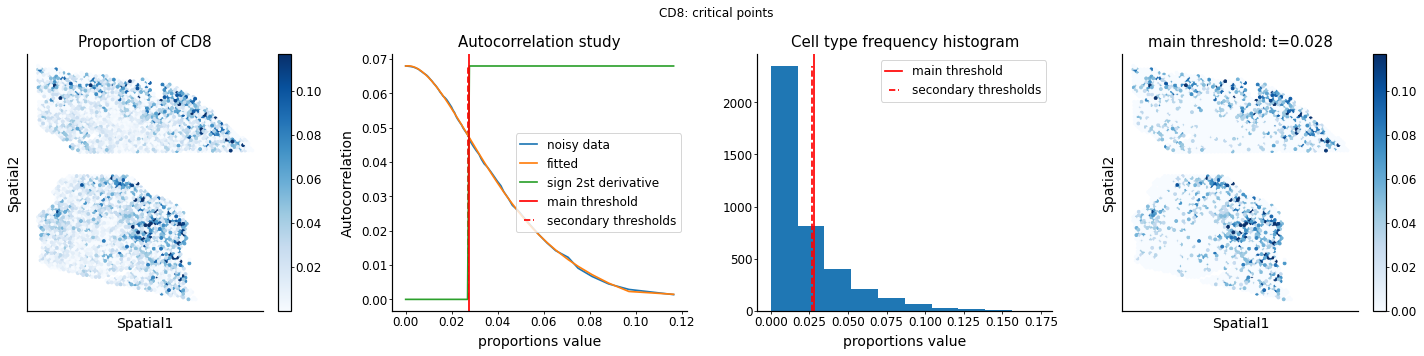

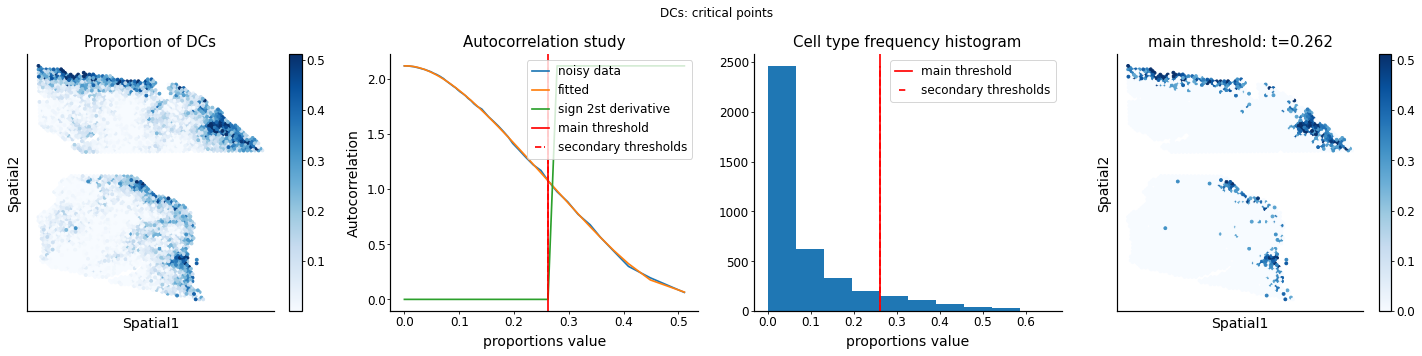

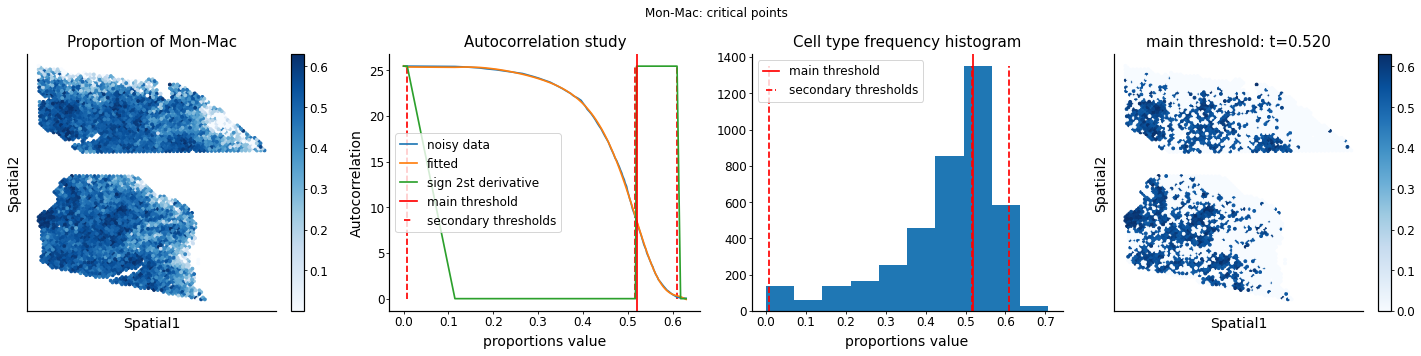

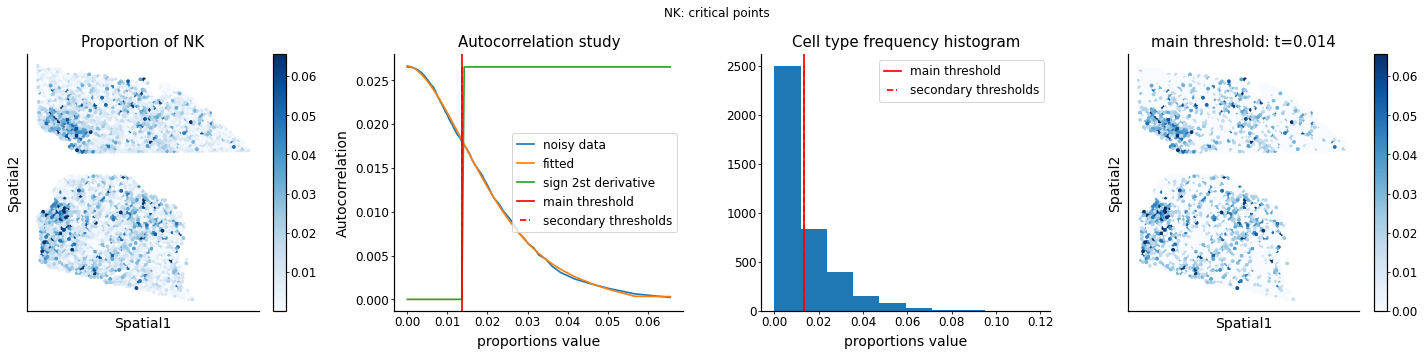

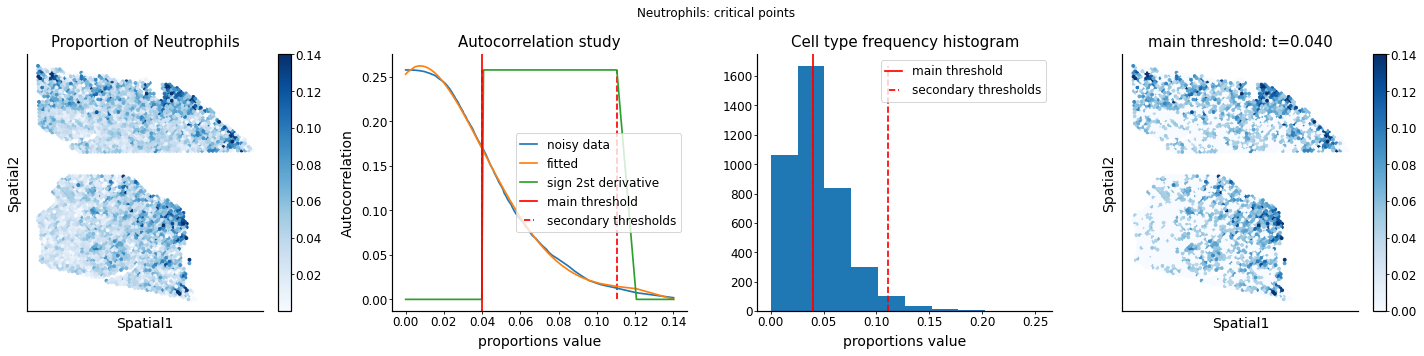

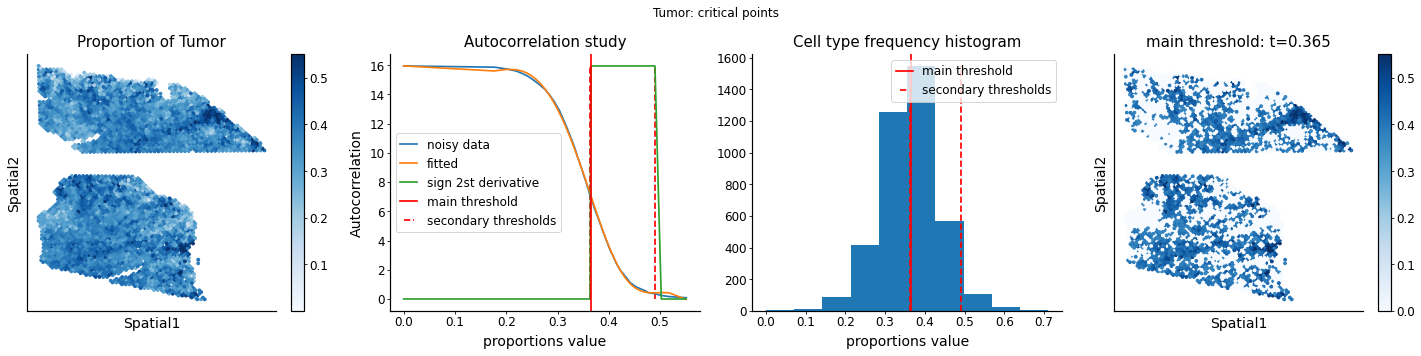

In [37]:
ct_thresholds = {}
nominal_threshold = {}

html = "<h2>Automatic thresholding</h2>"

for name_ct in ct_list:
    # show proportions
#     html += f"<h2>{name_ct} ANALYSIS:</h2>"
    array = st_adata.obsm["proportions"][name_ct]
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(name_ct+": critical points")
    ax1 = plt.subplot(141)
    prettify_axis(ax1, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
            c=array, s=8, cmap="Blues", vmax=vmax)
    plt.colorbar()
    plt.title("Proportion of "+name_ct)

    # get characteristic values
    quantiles, stack = form_stacked_quantiles(array.values)
    index, z_values = get_autocorrelations(st_adata, stack, quantiles)
    z_values, smoothed, derivative, sign_2nd, _ = smooth_get_critical_points(index, z_values, s=0.1)

    #plot characteristic plots
    ymax = np.max(z_values)
    ax2 = plt.subplot(142)
    prettify_axis(ax2)
    plt.plot(index, z_values, label="noisy data")
    plt.plot(index, smoothed, label="fitted")
    plt.plot(index, ymax * sign_2nd, label="sign 2st derivative")
    # identify points
    ipoints = index[np.where(sign_2nd[:-1] != sign_2nd[1:])[0]]
    plt.vlines(ipoints, ymin=0, ymax=np.max(z_values), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    nom_map = index[np.argmin(derivative)]
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.ylabel("Autocorrelation")
    plt.xlabel("proportions value")
    plt.title("Autocorrelation study")
    plt.legend()
    
    # plot on top of histogram
    ax3 = plt.subplot(143)
    prettify_axis(ax3)
    n, bins, patches = plt.hist(array.values)
    plt.vlines(ipoints, ymin=0, ymax=np.max(n), color="red", linestyle="--", label="secondary thresholds")
    # nominal mapping
    plt.axvline(nom_map, c="red", label="main threshold")
    plt.xlabel("proportions value")
    plt.title("Cell type frequency histogram")
    plt.legend()
    
    # add thresholds to dict
    nominal_threshold[name_ct] = nom_map
    ct_thresholds[name_ct] = ipoints
    
    ax4 = plt.subplot(144)
    prettify_axis(ax4, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")    # show binarization for every ipoint
    p = nom_map
    vmax = np.quantile(array.values, 0.99)
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], 
                c=array.values * (array.values > p), s=8, cmap="Blues", vmax=vmax)
    plt.title("main threshold: t={:0.3f}".format(p))
    plt.colorbar()
    plt.tight_layout()
    
    # DUMP TO HTML
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html += '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

# write HTML
with open('thresholding.html','w') as f:
    f.write(html)

### Now, for every cell type, we wish to explore the gamma space


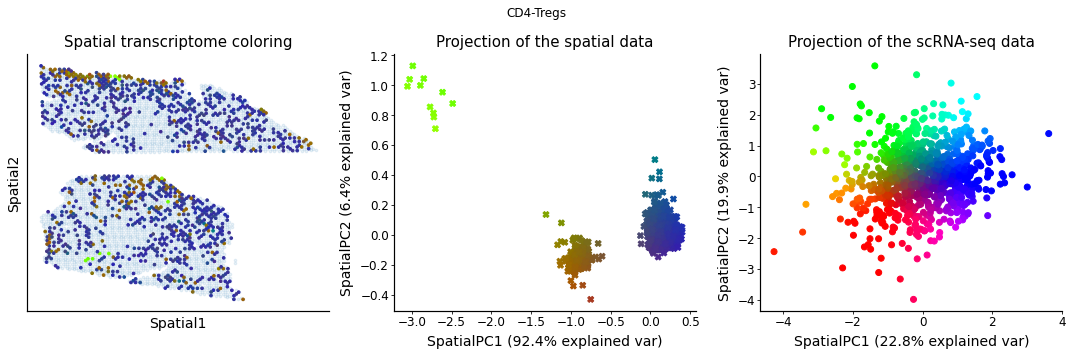

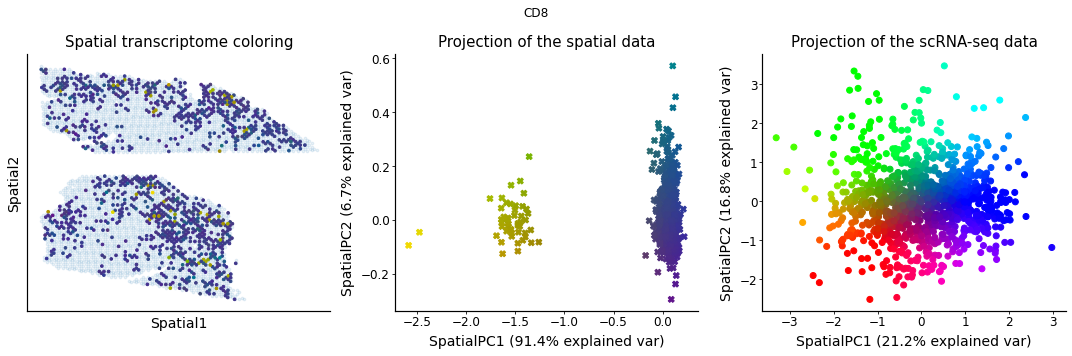

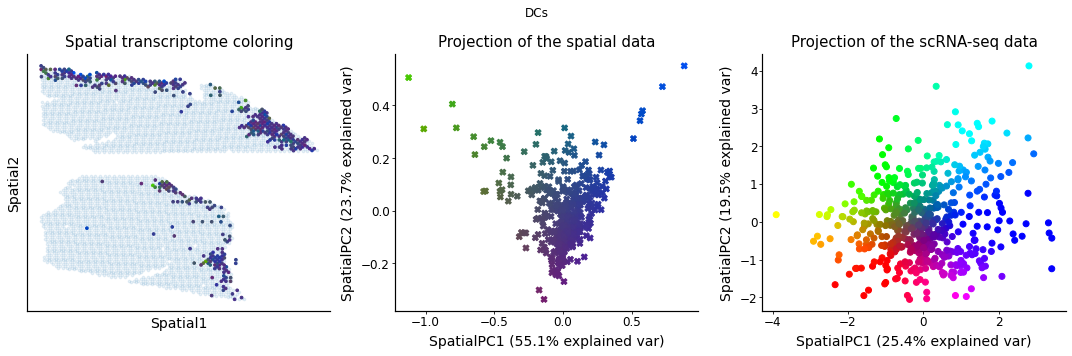

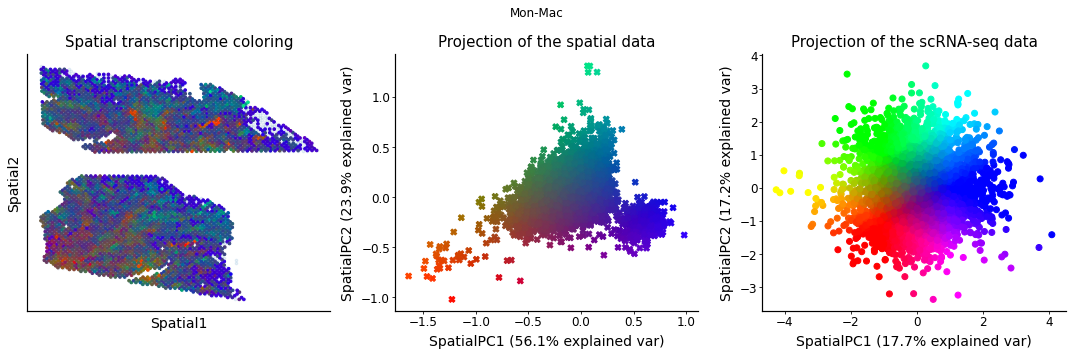

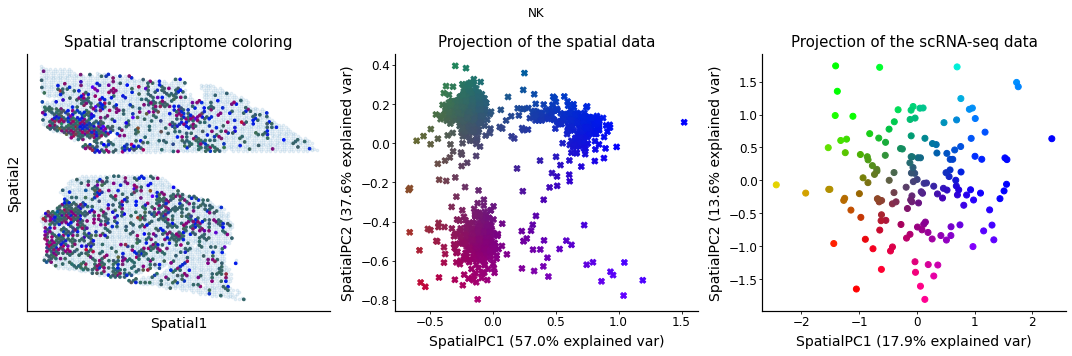

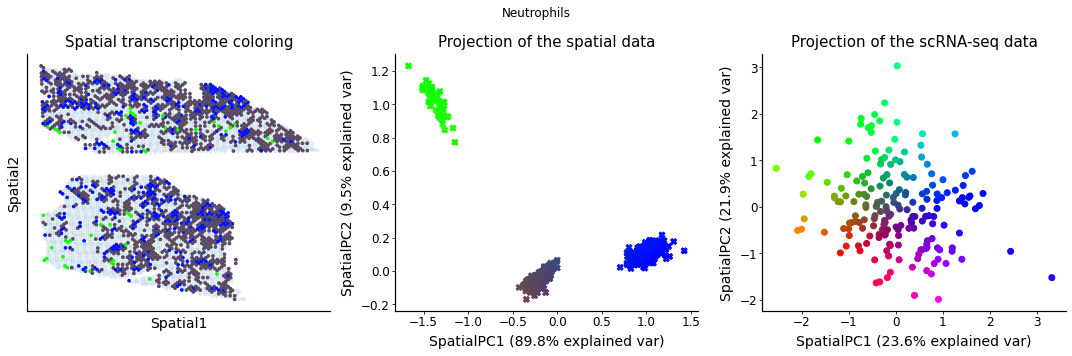

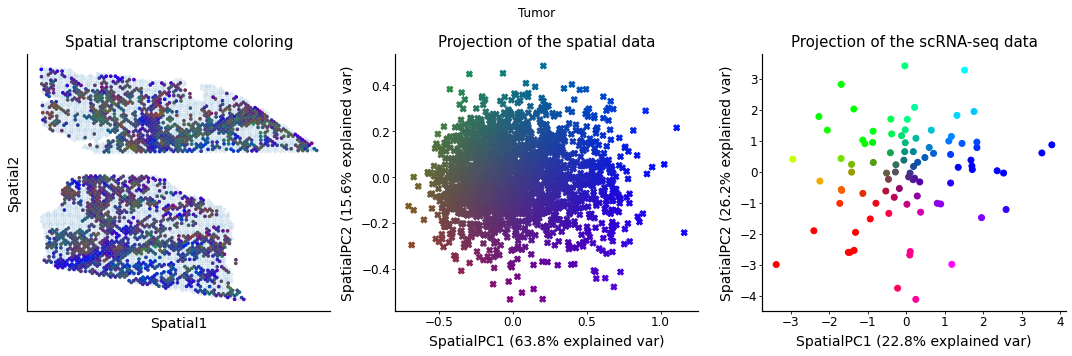

In [39]:
html = "<h1>sPCA analysis</h1>"

for name_ct in ct_list:
    # show proportions
#     html += f"<h3>{name_ct} ANALYSIS:</h2>"
    # find the components
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][name_ct].values[filter_]
    ct_index = np.where(name_ct == st_model.cell_type_mapping)[0][0]
    data = gamma[:, :, ct_index][filter_]
    vec = get_spatial_components(locations, proportions, data)
    # project data onto them
    projection = np.dot(data - np.mean(data, 0), vec)

    # create the colormap
    cmap = cmap2d.TernaryColorMap(tri_coords, tri_colors)

    # apply colormap to spatial data
    color = np.vstack([cmap(projection[i]) for i in range(projection.shape[0])])
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(name_ct)
    ax1 = plt.subplot(132)
    prettify_axis(ax1)
    plt.scatter(projection[:, 0], projection[:, 1],c=color, marker="X")
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(data.T)))
    explained_var = 100 * np.diag(np.cov(projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the spatial data")

    ax3 = plt.subplot(131)
    prettify_axis(ax3, False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.1, s=7)
    plt.scatter(st_adata.obsm["location"][filter_, 0], st_adata.obsm["location"][filter_, 1], 
                c=color, s=7)
    plt.title("Spatial transcriptome coloring")

    # go back to the single-cell data and find gene correlated with the axis
    sc_adata_slice = sc_adata[sc_adata.obs["broad_labels"] == name_ct]
    normalized_counts = sc_adata_slice.X.A
    sc_latent = sc_adata_slice.obsm["X_CondSCVI"]
    sc_projection = np.dot(sc_latent - np.mean(sc_latent,0), vec)

    # show the colormap for single-cell data
    color = np.vstack([cmap(sc_projection[i]) for i in range(sc_projection.shape[0])])
    ax2 = plt.subplot(133)
    prettify_axis(ax2)
    plt.scatter(sc_projection[:, 0], sc_projection[:, 1],c=color)
    # variance and explained variance
    total_var = np.sum(np.diag(np.cov(sc_latent.T)))
    explained_var = 100 * np.diag(np.cov(sc_projection.T)) / total_var 
    plt.xlabel("SpatialPC1 ({:.1f}% explained var)".format(explained_var[0]))
    plt.ylabel("SpatialPC2 ({:.1f}% explained var)".format(explained_var[1]))
    plt.title("Projection of the scRNA-seq data")
    plt.tight_layout()

    # DUMP TO HTML
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html += '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    
    # calculate correlations, and for each axis:
    # (A) display top 50 genes + AND - (B) for each gene set, get GSEA 
    for d in [0, 1]:
        html += f"<h4>Component:{d}</h4>"
        r = vcorrcoef(normalized_counts.T, sc_projection[:, d])
        for mode in ["top", "bottom"]:
            ranking = np.argsort(r)
            if mode == "top":
                ranking = ranking[::-1]
            gl = list(st_adata.var.index[ranking[:50]])
            enr = gseapy.enrichr(gene_list=gl, description='pathway', 
                                 gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
            html += f"<h5> {mode} </h5>"
            html += "<p>" + ", ".join(gl) + "</p>"
            html += "<p>" + ", ".join(enr.results.head(10)["Term"].values) + "</p>"
            
# write HTML
with open('sPCA.html','w') as f:
    f.write(html)

### Last piece of automated analysis, look for Hotspot modules in the imputed values

In [40]:
html = "<h1>Hotspot analysis</h1>"
for name_ct in ct_list:
    # show proportions
    html += f"<h5>{name_ct} ANALYSIS:</h5>"

    # get data
    filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
    locations = st_adata.obsm["location"][filter_]
    proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

    # impute
    imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

    # run hotspot
    loc = pd.DataFrame(data=locations, index=st_adata.obs.index[filter_])
    df = pd.DataFrame(data=imp_ge.T, 
                      columns=st_adata.obs.index[filter_], index=st_adata.var.index)
    # run hotspot
    hs = hotspot.Hotspot(df, model='none', latent=loc,)
    hs.create_knn_graph(
            weighted_graph=True, n_neighbors=5,
        )
    hs_results = hs.compute_autocorrelations(jobs=1)

    gl = list(hs_results.index[:50])
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)

    # dump HTML
    html += "<p>" + ", ".join(gl) + "</p>"
    html += "<p>" + ", ".join(enr.results.head(10)["Term"].values) + "</p>"
    
# write HTML
with open('hotspot.html','w') as f:
    f.write(html)

100%|██████████| 2886/2886 [00:00<00:00, 12049.60it/s]


## then, quick API for plotting genes in a given cell type

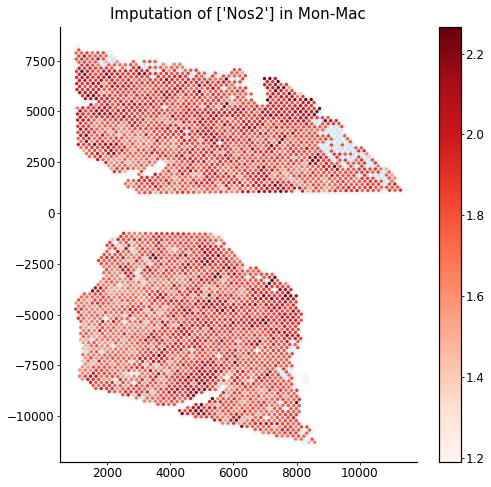

In [83]:
plt.figure(figsize=(8, 8))

name_ct = "Mon-Mac"
# gene_name = ["Hmox1", "Hilpda", "Gpnmb"]
gene_name=["Nos2"]


# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

# impute
imp_ge = np.sum(st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0])[gene_name].values, 1)
imp_ge = np.log(1 + 1e5 * imp_ge)
vmax = np.quantile(imp_ge, 0.99)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_ge, s=5, cmap="Reds", vmax=vmax)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {name_ct}")
plt.show()

# Refined analysis of macrophages

In [40]:
# Step 1, run hotpost and check the modules
# Step 2, check those modules on the single-cell data
# Step 3, do a molecular signature analysis of the hypoxic zone vs the rest

In [42]:
# run hotspot
name_ct = "Macrophages"
sc_adata_slice = sc_adata[sc_adata.obs["broad_labels_"] == name_ct]
loc = pd.DataFrame(data=sc_adata_slice.obsm["X_CondSCVI"], index=sc_adata_slice.obs.index)
df = pd.DataFrame(data=sc_adata_slice.X.A.T, columns=sc_adata_slice.obs.index, index=sc_adata_slice.var.index)
# run hotspot
hs = hotspot.Hotspot(df, model='danb', latent=loc,)
hs.create_knn_graph(
        weighted_graph=True, n_neighbors=20,
    )
hs_results = hs.compute_autocorrelations(jobs=1)


Removing 69 undetected/non-varying genes


100%|██████████| 2817/2817 [00:01<00:00, 2471.44it/s]


In [85]:
hs_genes = hs_results.index[hs_results["FDR"] < 0.0005]
hs_genes

Index(['Gm42418', 'Gm26917', 'Hp', 'Lyz2', 'H2-Aa', 'Plac8', 'H2-Eb1', 'Ifit3',
       'Cd74', 'Rsad2',
       ...
       'Bgn', 'Wls', 'Pnp2', 'Batf', 'Ccdc58', 'Esyt1', 'Rnf144a', 'Dst',
       'Skap1', 'Ssr2'],
      dtype='object', name='Gene', length=786)

In [ ]:
local_correlations = hs.compute_local_correlations(hs_genes, jobs=4)

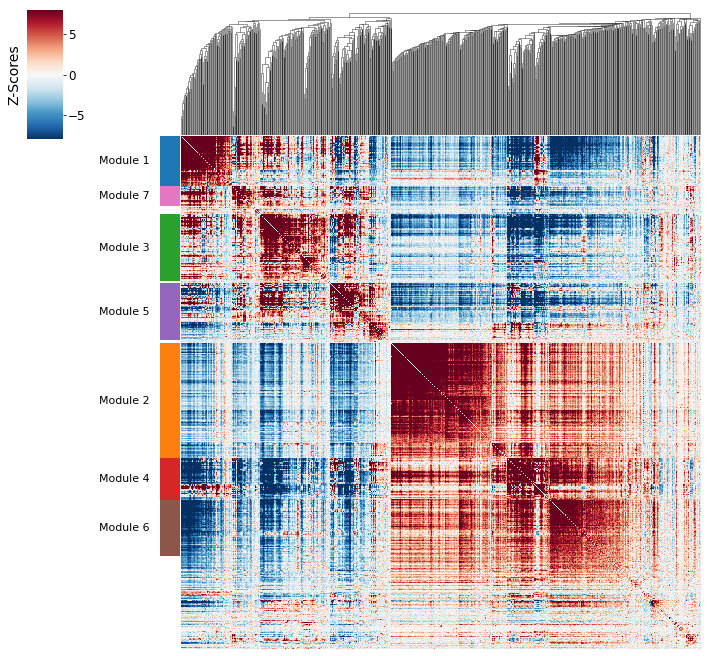

In [101]:
modules = hs.create_modules(
    min_gene_threshold=30, core_only=True, fdr_threshold=0.1
)

hs.plot_local_correlations()

In [113]:
for module in range(1, 8):
    print(f"Module {module}:")
    gl = list(hs.results.loc[hs.modules.index[np.where(hs.modules == module)[0]]].index[:50])
    print(", ".join(gl) + "\n")
    enr = gseapy.enrichr(gene_list=gl, description='pathway', gene_sets='BioPlanet_2019', outdir='test', no_plot=True)
    print(", ".join(enr.results.head(10)["Term"].values) + "\n")

Module 1:
Ifit3, Rsad2, Ifit2, Cxcl10, Ifit1, Ifit1bl1, Ly6a, Gbp2, Slfn5, Cmpk2, Ifi205, Ifit3b, Usp18, Isg20, Slfn4, Oasl1, Ifi208, AW112010, Mxd1, Irgm1, Samd9l, Phf11d, Socs1, Igtp, Ifih1, Ly6i, Pnp, Gbp5, Slfn9, Acod1, Cd69, Slamf7, Iigp1, Bst2, Tlr9, Ccl5, Scimp, Cd40, Il18bp, Klrk1, Ccl4, Flt1, Rilpl1, Sectm1a, Gm4951, Ifi44, Lipg, Gm13822, Tnfsf8, Ifi214

Interferon alpha/beta signaling, Interferon signaling, Immune system signaling by interferons, interleukins, prolactin, and growth hormones, TNF-alpha effects on cytokine activity, cell motility, and apoptosis, Toll-like receptor signaling pathway regulation, Immune system, Cytokine-cytokine receptor interaction, Type II interferon signaling (interferon-gamma), Malaria, Binding of chemokines to chemokine receptors

Module 2:
Birc5, Selenop, Cdca3, Mki67, Stmn1, Cdca8, Ccnb2, Cks1b, Nusap1, Ccna2, Cenpe, Knstrn, Ckap2l, Ube2c, Plk1, Ccnb1, Cenpf, Mcm6, Cenpa, Top2a, Asf1b, Anln, Tpx2, Kif20b, Smc2, Cdk1, Kif11, Prc1, Tacc3, Hmm

In [127]:
hs.modules[["C1qa", "C1qa", "Cx3cr1", "Spp1", "Apoe", "Ms4a7"]]

Gene
C1qa      4
C1qa      4
Cx3cr1    4
Spp1      4
Apoe      5
Ms4a7     4
Name: Module, dtype: int64

In [162]:
hs.modules[["Arg1", "Hmox1", "Hilpda", "Gpnmb", "Mmp12", "Il7r"]]

Gene
Arg1      5
Hmox1     5
Hilpda    5
Gpnmb     5
Mmp12     5
Il7r      5
Name: Module, dtype: int64

In [85]:
# Modules of interest
# ------ Arg1-
# ---------- MHC-II Module 7 
gene_mhc = ["H2-Aa", "H2-Eb1", "Cd74", "H2-Ab1", "H2-DMb1"]
# ---------- Monocytes markers Module 3
gene_mono = ["Ly6c2", "Plac8", "Ly6a"]
# ---------- INF I Module 1
gene_ifn = ["Ifit1", "Ifit2", "Ifit3", "Isg15"]
# ------ Arg1+
# ---------- Hypoxia Module 5 / Mreg 
gene_hypox = ["Arg1", "Hmox1", "Hilpda", "Gpnmb", "Mmp12", "Il7r"]
# ---------- C1qa Module 4 / Tumor associated macrophages
gene_ctam = ["C1qa", "C1qa", "Cx3cr1", "Spp1", "Apoe", "Ms4a7"]

In [86]:
import umap
dim_red = umap.UMAP(n_neighbors=30)
slice_data = sc_adata[sc_adata.obs["broad_labels"] == "Mon-Mac"]
result = dim_red.fit_transform(slice_data.obsm["X_scVI"])

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [87]:
name_ct = "Mon-Mac"
# get data
filter_ = st_adata.obsm["proportions"][name_ct].values > ct_thresholds[name_ct][0]
locations = st_adata.obsm["location"][filter_]
proportions = st_adata.obsm["proportions"][name_ct].values[filter_]

# impute
imp_ge = st_model.get_scale_for_ct(name_ct, indices=np.where(filter_)[0]).values

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


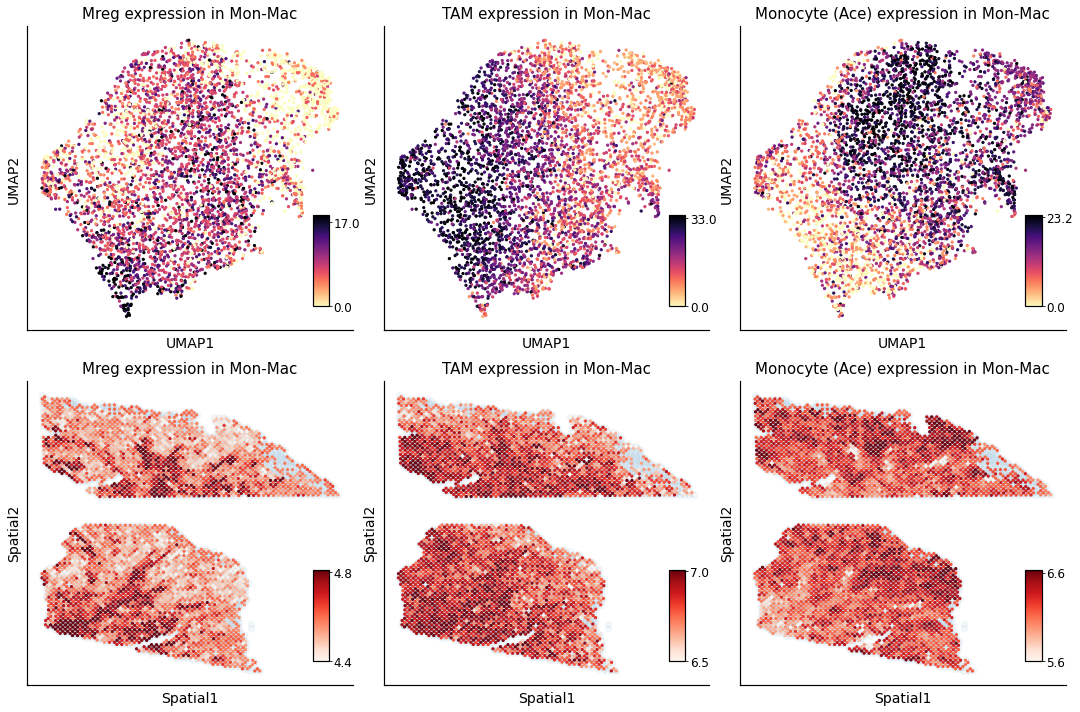

In [98]:
plt.figure(figsize=(15, 10))
names = ["Mreg", "TAM", "Monocyte (Ace)"]
for i, gene_name in enumerate([gene_hypox, gene_ctam, gene_mono]):
    gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]

    # top plot
    ax1 = plt.subplot(2, 3, 1 + i)
    vector = np.sum(slice_data.X.A[:, gene_idx], axis=1)
    vmax = np.quantile(vector, 0.95)
    sc_plot = plt.scatter(result[:, 0], result[:, 1], c=vector, s=5, cmap="magma_r", vmax=vmax)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"{names[i]} expression in Mon-Mac")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(vector, 0.01),np.quantile(vector, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(sc_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    # bottom plot
    ax1 = plt.subplot(2, 3, 1 + i+3)
    imp_module = np.sum(imp_ge[:, gene_idx], 1)
    imp_module = np.log(1 + 1e5 * imp_module)
    vmax = np.quantile(imp_module, 0.94)
    vmin = np.quantile(imp_module, 0.01)
    # plot
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
    st_plot = plt.scatter(locations[:, 0], locations[:, 1], 
                c=imp_module, s=5, cmap="Reds", vmax=vmax, vmin=vmin)
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.title(f"{names[i]} expression in Mon-Mac")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(imp_module, 0.01), np.quantile(imp_module, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(st_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    
plt.tight_layout()
plt.savefig("figures/Mac_gene_expression.pdf")

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel/__main__.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


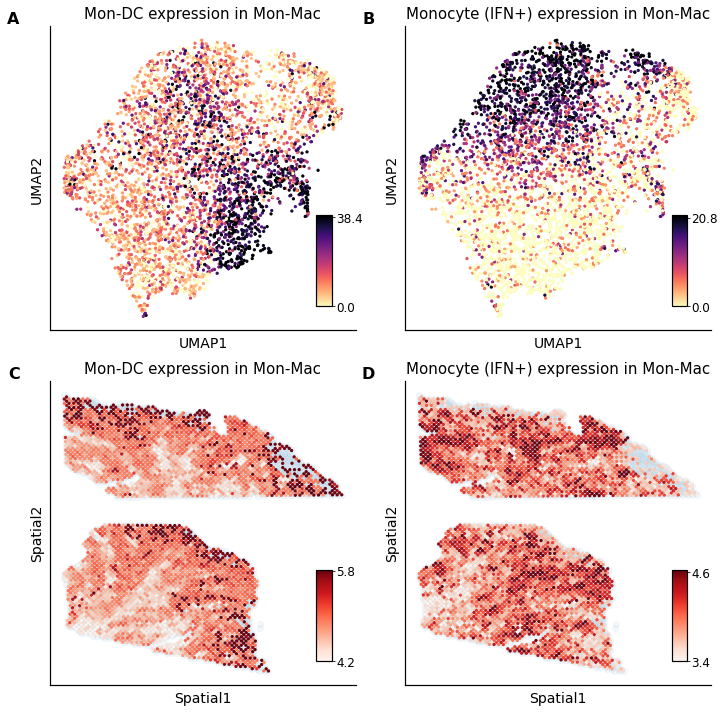

In [100]:
plt.figure(figsize=(10, 10))
names = ["Mon-DC", "Monocyte (IFN+)"]
panel_name=[["A", "B"], ["C", "D"]]
for i, gene_name in enumerate([gene_mhc, gene_ifn]):
    gene_idx = np.where([x in gene_name for x in st_adata.var.index])[0]

    # top plot
    ax1 = plt.subplot(2, 2, 1 + i)
    ax1.text(-0.1, 1.05, panel_name[0][i], transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    vector = np.sum(slice_data.X.A[:, gene_idx], axis=1)
    vmax = np.quantile(vector, 0.95)
    sc_plot = plt.scatter(result[:, 0], result[:, 1], c=vector, s=5, cmap="magma_r", vmax=vmax)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"{names[i]} expression in Mon-Mac")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(vector, 0.01),np.quantile(vector, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(sc_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    # bottom plot
    ax1 = plt.subplot(2, 2, 1 + i+2)
    ax1.text(-0.1, 1.05, panel_name[1][i], transform=ax1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    imp_module = np.sum(imp_ge[:, gene_idx], 1)
    imp_module = np.log(1 + 1e5 * imp_module)
    vmax = np.quantile(imp_module, 0.94)
    vmin = np.quantile(imp_module, 0.01)
    # plot
    plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
    st_plot = plt.scatter(locations[:, 0], locations[:, 1], 
                c=imp_module, s=5, cmap="Reds", vmax=vmax, vmin=vmin)
    plt.xlabel("Spatial1")
    plt.ylabel("Spatial2")
    plt.title(f"{names[i]} expression in Mon-Mac")
    plt.xticks([])
    plt.yticks([])
    a, b = np.quantile(imp_module, 0.01), np.quantile(imp_module, 0.93)
    ta, tb = ["{:0.1f}".format(x) for x in (a, b)]
    cax = inset_axes(plt.gca(), width="5%", height="30%", loc=4, borderpad=2) 
    cbar = plt.colorbar(st_plot, cax=cax, orientation="vertical")
    cbar.set_ticks([a, b])
    cbar.set_ticklabels([ta, tb])
    
plt.tight_layout()
plt.savefig("figures/supp_Mac_gene_expression.pdf")

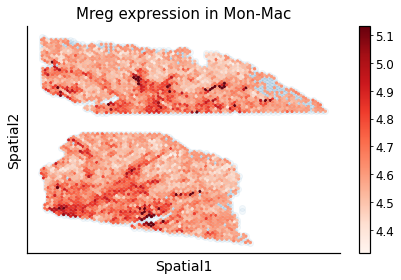

In [69]:
# now let's define an hypoxic zone and perform DE
gene_idx = np.where([x in gene_hypox for x in st_adata.var.index])[0]
imp_module = np.sum(imp_ge[:, gene_idx], 1)
imp_module = np.log(1 + 1e5 * imp_module)
vmax = np.quantile(imp_module, 0.99)
vmin = np.quantile(imp_module, 0.01)
# plot
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(locations[:, 0], locations[:, 1], 
            c=imp_module, s=5, cmap="Reds", vmax=vmax)
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.title(f"{names[0]} expression in Mon-Mac")
plt.xticks([])
plt.colorbar()
plt.yticks([])
plt.tight_layout()
plt.show()


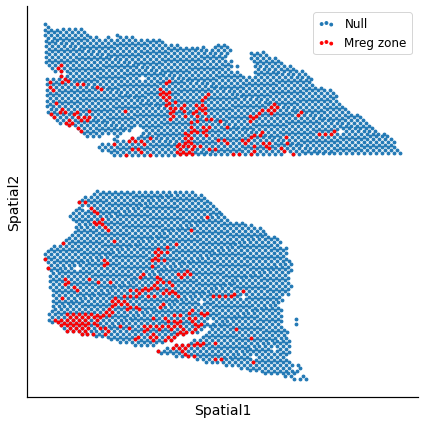

In [75]:
plt.figure(figsize=(6, 6))
threshold=4.8
mask_hypoxia = imp_module > threshold
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], label="Null", s=8)
plt.scatter(locations[mask_hypoxia, 0], locations[mask_hypoxia, 1], s=8, c="r", vmax=vmax, label="Mreg zone")
plt.xlabel("Spatial1")
plt.ylabel("Spatial2")
plt.xticks([])
plt.legend(frameon=True)
plt.yticks([])
plt.tight_layout()
plt.show()

In [53]:
# get statistics
avg_library_size = np.mean(np.sum(st_adata.layers["counts"], axis=1).flatten())
exp_px_o = st_model.module.px_o.detach().exp().cpu().numpy()
mean = avg_library_size * imp_ge

# create distribution
concentration = torch.tensor(avg_library_size * imp_ge / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

mask_non_hypoxia = np.random.choice(np.where(~mask_hypoxia)[0], size=(361))

# slice conditions
print(np.sum(mask_hypoxia), np.sum(mask_non_hypoxia))

# generate 
Na, Nb = (10, 10)
simulated_case = Gamma(concentration=concentration[mask_hypoxia], rate = rate).sample((Na,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration[mask_non_hypoxia], rate = rate).sample((Nb,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

379 707767


In [54]:
de_ks =np.array([ks_2samp(simulated_case[:, gene], 
                       simulated_control[:, gene], 
                       alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])

In [62]:
de_ks[de_ks == 0] = np.min(de_ks[de_ks > 0])

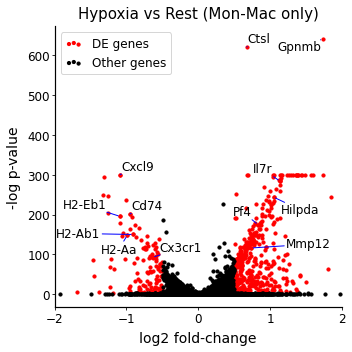

In [74]:
de = de_ks
max_pval = np.max(de[multipletests(de, method='fdr_bh')[0]])
lfc = np.log2(mean[mask_hypoxia].mean(0)) - np.log2(mean[mask_non_hypoxia].mean(0))
plt.figure(figsize=(5, 5))
# plot DE genes
mask = (de < max_pval) * (np.abs(lfc) > 0.5)
de_scatter = plt.scatter(lfc[mask], np.clip(-np.log(de[mask]), 0, 300), s=10, c="r")
nde_scatter = plt.scatter(lfc[~mask], np.clip(-np.log(de[~mask]), 0, 300), s=10, c="black")
plt.xlabel("log2 fold-change")
plt.ylabel("-log p-value")
plt.xlim((-2, 2))
plt.legend((de_scatter, nde_scatter), ("DE genes", "Other genes"), frameon=True)

interesting_genes = ["Gpnmb", "Hilpda", "Cx3cr1", "Mmp12", "Ctsl", "Pf4", "Il7r",
                     "H2-Aa", "H2-Ab1", "H2-Eb1", "Cxcl9", "Cd74"]
texts = []
for i, gene in enumerate(interesting_genes):
    ind = np.where(st_adata.var.index == gene)[0]
    x_coord, y_coord = lfc[ind], -np.log(de)[ind]
    plt.scatter(x_coord, y_coord, c="r", s=10)
    texts += [plt.text(x_coord, y_coord, gene, fontsize=12)]
adjust_text(texts, lfc, -np.log(de), arrowprops=dict(arrowstyle="-", color='blue'))
plt.title("Hypoxia vs Rest (Mon-Mac only)")
plt.tight_layout()
plt.savefig("figures/volcano_Hypoxia.pdf", dpi=DPI)

In [73]:
print("Hypoxia enriched: " + ", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < max_pval ))[0]].values))
print("Null enriched: " + ", ".join(st_adata.var.index[np.where((lfc < -0.5) * (de < max_pval ))[0]].values))

Hypoxia enriched: 1700003F12Rik, 1810021B22Rik, 3110039M20Rik, 4930556M19Rik, 4930579C12Rik, 4930579K19Rik, 4932422M17Rik, 4933407K13Rik, 4933431E20Rik, 5430403G16Rik, A530013C23Rik, AA986860, Aamdc, Abca1, Abcb1a, Acp5, Actg2, Adat1, Adm, Alms1, Amacr, Amer1, Amigo2, Angpt1, Ankrd33b, Ankrd55, Apold1, Arap2, Areg, Arhgap32, Arhgap33, Armcx4, Arsg, Asns, Aspm, Atad2, Atf5, B4galt2, B9d1, BC049352, Bcat1, Bdkrb2, Bhlhb9, Bhlhe22, Bicd1, Birc5, Bok, Brdt, Brip1, Bub1b, C330013E15Rik, Cacna2d1, Card10, Casc4, Cav1, Cbx5, Ccdc157, Ccne1, Ccne2, Cd200, Cd63, Cd83, Cd93, Cdc25c, Cdc42bpa, Cdc42ep1, Cdca7l, Cdh13, Cdr2l, Cela1, Ces1g, Chac1, Chst1, Ciart, Clu, Col11a1, Col27a1, Col4a1, Col5a3, Col6a3, Colec12, Coq8a, Cpe, Crabp2, Cryab, Cryba4, Cth, Ctla2a, Ctsl, Cul7, Cxcl1, Cxcl12, Cxcl2, Cyp7b1, Cystm1, Dctd, Dgat1, Dlg3, Dmwd, Dnah8, Dnmt3l, Dnph1, Dppa3, Dtl, Dusp14, Dusp4, Dyrk3, E2f7, Echdc3, Ecscr, Ednrb, Eepd1, Efna5, Emp1, Emp2, Enpp1, Epb41l4a, Epdr1, Ercc6l, Ereg, Esco2, Esf1, Evc

In [65]:
print(", ".join(st_adata.var.index[np.where((lfc > 0.5) * (de < np.exp(-150) ))[0]].values))

Abca1, Adam8, Adm, Ager, Arg1, Bnip3, Ccl6, Ccl7, Ccl9, Cd63, Colec12, Csrnp2, Ctsl, Ddah2, Echdc3, Emp1, Etv1, F13a1, Fabp5, Folr2, Fosl1, Galnt18, Gja1, Gpihbp1, Gpnmb, Gstm5, Hilpda, Hist1h2bc, Hmox1, Hoxa9, Ier3, Inhba, Ltbp1, Lzts2, Me1, Mmp12, Ms4a14, Msln, Mt1, Mt2, Mtcl1, Nceh1, Ndrg1, Ninj1, Obsl1, P4ha2, Pacsin3, Pf4, Ppp1r13l, Pyroxd2, Rassf8, Rcn3, Rtkn, S100g, Sdc4, Slc27a3, Snhg12, Snhg18, Sorbs3, Syngr1, Tceal8, Thbs1, Tmem37, Tspan3, Tspan9, Vat1, Vcl, Vldlr, Wwtr1, Ypel2
